In [50]:
%pip install cvxopt

import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
import cvxopt
from courselib.utils.normalization import standardize
from courselib.utils.splits import train_test_split
from courselib.models.svm import LinearSVM
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import binary_accuracy
from courselib.models.glm import LogisticRegression
from courselib.utils.metrics import cross_entropy

# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
    print(f"{repo_root} added to sys.path.")
else:
    print("Repo root already in sys.path.")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Repo root already in sys.path.


In [51]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    df = pd.DataFrame(data)
    df.columns = df.columns.droplevel(1)
    return df

def simple_moving_average(data, window=15):
    df = data.copy()
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

def exponential_moving_average(data, span=20):
    df = data.copy()
    df[f'EMA_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()
    return df


def relative_strength_index_ema(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.ewm(window,adjust=False).mean()
    avg_loss = down.ewm(window,adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_ema'] = 100 - (100 / (1 + rs))
    return df

def relative_strength_index_sma(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_sma'] = 100 - (100 / (1 + rs))
    return df


def bollinger_bands(data):
    df = data.copy()
    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std
    return df

def macd_ewm(data):
    df = data.copy()
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df


def daily_return(data):
    df= data.copy()
    df['Daily_Return'] = df['Close'].pct_change()
    return df

def rolling_volatility(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()
    return df

def lagged_returns(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Lag_1'] = df['Daily_Return'].shift(1)
    df['Lag_2'] = df['Daily_Return'].shift(2)
    df['Lag_3'] = df['Daily_Return'].shift(3)
    return df

def compute_technical_indicators(data):
    df = data.copy()
    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

In [52]:
data = fetch_data('SPY', '2015-01-01', '2025-07-31')
data = simple_moving_average(data, window=15)
data = exponential_moving_average(data, span=20)
data = relative_strength_index_ema(data, window=14)
data = relative_strength_index_sma(data, window=14)
data = bollinger_bands(data)
data = macd_ewm(data)
data = daily_return(data)
data = rolling_volatility(data)
data = lagged_returns(data)
data = compute_technical_indicators(data)

C:\Users\Micha\AppData\Local\Temp\ipykernel_28792\1736392114.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [53]:
data['Daily_Return_Sign'] = np.where(data['Daily_Return'] > 0, 1, -1)
data['Daily_Return_Sign'] = data['Daily_Return_Sign'].shift(-1)  
data.dropna()
data = data.drop(columns=['High','Low','Open','Volume'])  
raw_data = data.copy()
data.dropna(inplace=True)  


In [54]:

X, Y, X_train, Y_train, X_test, Y_test = train_test_split(data, training_data_fraction=0.7, class_column_name='Daily_Return_Sign',shuffle = False,return_numpy=True)
X = standardize(X)
X_test = standardize(X_test)
X_train = standardize(X_train)


In [55]:
w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true), 
                "loss": lambda y_pred, y_true: np.mean(np.maximum(0, 1 - y_true * y_pred))}

svm = LinearSVM(w, b, optimizer, C=0.5)
metrics_history = svm.fit(X_train,Y_train, num_epochs = 20000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

In [56]:
svm.w, svm.b

(array([ 0.00087084,  0.00125312,  0.00124002, -0.00568053, -0.00589822,
         0.00107089,  0.00148162,  0.00074334,  0.00175984, -0.01592767,
         0.0018802 ,  0.00639427, -0.00589816, -0.00209035, -0.00432811]),
 array(0.09961894))

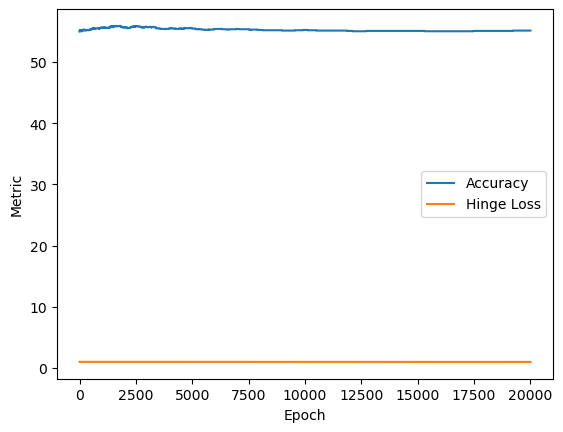

In [57]:
import matplotlib.pyplot as plt

plt.plot(metrics_history["accuracy"], label="Accuracy")
plt.plot(metrics_history["loss"], label="Hinge Loss")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.show()


In [58]:
y_pred_test = svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)


Test Accuracy: 54.568527918781726


In [59]:
from courselib.models.svm import BinaryKernelSVM
rbf_svm = BinaryKernelSVM(kernel='rbf',sigma = 0.5)
metrics_history = rbf_svm.fit(X_train,Y_train)
binary_acc = binary_accuracy(rbf_svm(X_train), Y_train)
binary_acc


96.73380511703866

In [60]:
y_pred_test = rbf_svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)
y_train_pred = rbf_svm(X_train)

Test Accuracy: 55.964467005076145


In [61]:
data['Daily_Return_Sign'] = data['Daily_Return_Sign'].replace({-1: 0})
data

Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign
Date,,,,,,,,,,,,,,,,
2015-01-30,166.573730,169.063658,169.370527,23.546725,39.839078,172.828012,165.551794,-0.636602,-0.474039,-0.012575,0.010508,0.009244,-0.012824,-0.013191,0.359085,1.0
2015-02-02,168.636612,168.933929,169.300631,28.787308,48.509646,172.510215,165.576455,-0.616091,-0.502449,0.012384,0.013018,-0.012575,0.009244,-0.012824,0.242203,1.0
2015-02-03,171.075272,169.055863,169.469644,34.476141,55.141657,172.744011,165.603227,-0.398462,-0.481652,0.014461,0.013672,0.012384,-0.012575,0.009244,2.321716,0.0
2015-02-04,170.423813,169.166105,169.560517,33.705476,56.060505,172.791591,165.909750,-0.275383,-0.440398,-0.003808,0.011650,0.014461,0.012384,-0.012575,0.818390,1.0
2015-02-05,172.144287,169.458969,169.806591,37.649256,63.335729,173.162798,165.856743,-0.038570,-0.360033,0.010095,0.011753,-0.003808,0.014461,0.012384,0.016708,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-02,620.450012,605.347306,603.892113,72.221941,71.745537,621.082710,585.144670,9.265255,8.200720,0.004533,0.002937,-0.000324,0.004781,0.004968,24.681213,1.0
2025-07-03,625.340027,607.064144,605.934772,74.716437,73.148878,624.667921,584.676116,9.848618,8.530299,0.007881,0.002954,0.004533,-0.000324,0.004781,29.661011,0.0
2025-07-07,620.679993,608.311450,607.339079,68.441061,76.277021,626.316802,585.965040,9.821694,8.788578,-0.007452,0.005988,0.007881,0.004533,-0.000324,26.399963,0.0


In [62]:

training_data_fraction = .8
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(data, training_data_fraction=0.8, class_column_name='Daily_Return_Sign', shuffle=False, return_numpy=True)
X = standardize(X)
X_test = standardize(X_test)
X_train = standardize(X_train)

w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true, class_labels=[0, 1]), 
                "loss": lambda y_pred, y_true: cross_entropy(y_pred, y_true)}
logistic_regression = LogisticRegression(w, b, optimizer)
metrics_history = logistic_regression.fit(X_train, Y_train, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)
logistic_regression.w, logistic_regression.b

(array([-0.00951822, -0.00813031, -0.0081732 , -0.01248737, -0.01943805,
        -0.01174684, -0.00390385,  0.00968358,  0.01483482, -0.06491504,
        -0.0176402 ,  0.01287429, -0.01639134, -0.03921484, -0.00460602]),
 array(0.114299))

In [63]:
y_pred_test = logistic_regression(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 57.14285714285714


In [64]:

def pca_numpy(X: np.ndarray, n_components: int = 2):
    """
    Perform PCA using numpy.

    Parameters:
    -----------
    X : np.ndarray
        The input data matrix, shape (n_samples, n_features).
    n_components : int
        Number of principal components to keep.

    Returns:
    --------
    X_reduced : np.ndarray
        The projected data onto top principal components.
    explained_variance_ratio : np.ndarray
        Percentage of variance explained by each selected component.
    components : np.ndarray
        The eigenvectors (principal axes).
    """
    # 1) Center the data
    X_meaned = X - np.mean(X, axis=0)

    # 2) Covariance matrix
    cov_mat = np.cov(X_meaned, rowvar=False)

    # 3) Eigen decomposition
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

    # 4) Sort eigenvalues and eigenvectors in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[sorted_index]
    eigen_vectors = eigen_vectors[:, sorted_index]

    # 5) Select top k eigenvectors
    eigenvector_subset = eigen_vectors[:, 0:n_components]

    # 6) Project the data
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    # 7) Explained variance ratio
    explained_variance_ratio = eigen_values / np.sum(eigen_values)

    return X_reduced, explained_variance_ratio[:n_components], eigenvector_subset


In [65]:
X_reduced, explained_var, components = pca_numpy(X, n_components=5)
X_reduced, explained_var, components

(array([[ 3.45936147,  1.3006004 , -1.53685825,  0.26600143,  0.94651872],
        [ 3.26383933,  0.74633485,  1.43540281,  1.43554615, -0.19463494],
        [ 3.01430997,  0.06917663, -0.20125062, -1.48523083, -0.86020858],
        ...,
        [-6.29840045, -1.42179965, -0.59700781,  0.15512004,  0.8639756 ],
        [-6.20426817, -1.13086359, -0.02455604,  0.97330879, -0.30711866],
        [-6.3243817 , -1.39340735, -0.51499495, -0.02862681, -0.9098167 ]]),
 array([0.34954708, 0.26754654, 0.0879774 , 0.08117725, 0.06498529]),
 array([[-0.41488345,  0.15316725,  0.02808081, -0.03240936,  0.00501   ],
        [-0.40842687,  0.17577372,  0.01135387, -0.01425637,  0.00201259],
        [-0.40753445,  0.17781771,  0.01717222, -0.02196599,  0.00349213],
        [-0.1528432 , -0.41933953,  0.10993536, -0.12152253,  0.03617367],
        [-0.12905376, -0.39809927,  0.12429352, -0.15689455,  0.05438046],
        [-0.40193103,  0.19223444,  0.02769135, -0.0341824 ,  0.00583304],
        [-0.409

In [66]:
split_idx = int(round(0.8 * len(data)))
test_indices = data.index[split_idx:]
y_test_pred = rbf_svm(X_test)

raw_data['rbf_svm_pred'] = np.nan
raw_data.loc[test_indices, 'rbf_svm_pred'] = y_test_pred
raw_data
# For another model, e.g. RBF SVM
#data['rbf_svm_pred'] = np.nan
#data.loc[test_indices, 'rbf_svm_pred'] = rbf_y_pred_test  # replace with your variable

# For logistic regression
#data['logreg_pred'] = np.nan
#data.loc[test_indices, 'logreg_pred'] = logreg_y_pred_test  # replace with your variable

Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign,rbf_svm_pred
Date,,,,,,,,,,,,,,,,,
2015-01-02,171.567978,NaN,171.567978,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
2015-01-05,168.469589,NaN,171.272893,0.000000,NaN,NaN,NaN,-0.247165,-0.049433,-0.018059,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
2015-01-06,166.882782,NaN,170.854787,0.000000,NaN,NaN,NaN,-0.564579,-0.152462,-0.009419,NaN,-0.018059,NaN,NaN,NaN,1.0,NaN
2015-01-07,168.962296,NaN,170.674550,4.721216,NaN,NaN,NaN,-0.640944,-0.250159,0.012461,NaN,-0.009419,-0.018059,NaN,NaN,1.0,NaN
2015-01-08,171.960556,NaN,170.797027,11.197833,NaN,NaN,NaN,-0.454292,-0.290985,0.017745,NaN,0.012461,-0.009419,-0.018059,NaN,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-03,625.340027,607.064144,605.934772,74.716437,73.148878,624.667921,584.676116,9.848618,8.530299,0.007881,0.002954,0.004533,-0.000324,0.004781,29.661011,-1.0,1.0
2025-07-07,620.679993,608.311450,607.339079,68.441061,76.277021,626.316802,585.965040,9.821694,8.788578,-0.007452,0.005988,0.007881,0.004533,-0.000324,26.399963,-1.0,1.0
2025-07-08,620.340027,609.984766,608.577264,67.994678,72.556770,627.972032,586.606411,9.661551,8.963173,-0.000548,0.005815,-0.007452,0.007881,0.004533,20.190002,1.0,1.0


In [67]:
#raw_data['rbf_svm_pred'] = raw_data['rbf_svm_pred'].replace(-1, 0)
raw_data

Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign,rbf_svm_pred
Date,,,,,,,,,,,,,,,,,
2015-01-02,171.567978,NaN,171.567978,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
2015-01-05,168.469589,NaN,171.272893,0.000000,NaN,NaN,NaN,-0.247165,-0.049433,-0.018059,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
2015-01-06,166.882782,NaN,170.854787,0.000000,NaN,NaN,NaN,-0.564579,-0.152462,-0.009419,NaN,-0.018059,NaN,NaN,NaN,1.0,NaN
2015-01-07,168.962296,NaN,170.674550,4.721216,NaN,NaN,NaN,-0.640944,-0.250159,0.012461,NaN,-0.009419,-0.018059,NaN,NaN,1.0,NaN
2015-01-08,171.960556,NaN,170.797027,11.197833,NaN,NaN,NaN,-0.454292,-0.290985,0.017745,NaN,0.012461,-0.009419,-0.018059,NaN,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-03,625.340027,607.064144,605.934772,74.716437,73.148878,624.667921,584.676116,9.848618,8.530299,0.007881,0.002954,0.004533,-0.000324,0.004781,29.661011,-1.0,1.0
2025-07-07,620.679993,608.311450,607.339079,68.441061,76.277021,626.316802,585.965040,9.821694,8.788578,-0.007452,0.005988,0.007881,0.004533,-0.000324,26.399963,-1.0,1.0
2025-07-08,620.340027,609.984766,608.577264,67.994678,72.556770,627.972032,586.606411,9.661551,8.963173,-0.000548,0.005815,-0.007452,0.007881,0.004533,20.190002,1.0,1.0


In [68]:
raw_data['rbf_svm_pred'] = raw_data['rbf_svm_pred'].shift(1)
raw_data.dropna(inplace=True)
raw_data['strategy_return'] = raw_data['Daily_Return'] * raw_data['rbf_svm_pred']
raw_data['cumulative_strategy'] = (1 + raw_data['strategy_return']).cumprod()
raw_data['cumulative_asset'] = (1 + raw_data['Daily_Return']).cumprod()
raw_data


Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign,rbf_svm_pred,strategy_return,cumulative_strategy,cumulative_asset
Date,,,,,,,,,,,,,,,,,,,,
2023-06-06,415.389648,406.617869,406.255894,65.412635,71.842680,415.998420,393.894378,3.965019,2.883858,0.002178,0.008197,-0.001916,0.014461,0.009501,8.967194,-1.0,1.0,0.002178,1.002178,1.002178
2023-06-07,413.953278,407.672441,406.988978,62.926698,65.214852,417.055094,394.353573,4.083418,3.123770,-0.003458,0.007641,0.002178,-0.001916,0.014461,12.092010,1.0,1.0,-0.003458,0.998712,0.998712
2023-06-08,416.457123,408.571739,407.890707,65.383741,63.834389,418.543877,394.444713,4.329384,3.364893,0.006049,0.007179,-0.003458,0.002178,-0.001916,17.507294,1.0,1.0,0.006049,1.004753,1.004753
2023-06-09,417.204376,409.262063,408.777723,66.102110,65.692692,419.895271,394.817839,4.532364,3.598387,0.001794,0.003737,0.006049,-0.003458,0.002178,14.799652,1.0,1.0,0.001794,1.006556,1.006556
2023-06-12,420.989197,410.244175,409.940720,69.533221,68.918462,421.785093,395.083428,4.941666,3.867043,0.009072,0.004741,0.001794,0.006049,-0.003458,13.373047,1.0,1.0,0.009072,1.015687,1.015687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-02,620.450012,605.347306,603.892113,72.221941,71.745537,621.082710,585.144670,9.265255,8.200720,0.004533,0.002937,-0.000324,0.004781,0.004968,24.681213,1.0,1.0,0.004533,1.458617,1.496910
2025-07-03,625.340027,607.064144,605.934772,74.716437,73.148878,624.667921,584.676116,9.848618,8.530299,0.007881,0.002954,0.004533,-0.000324,0.004781,29.661011,-1.0,-1.0,-0.007881,1.447121,1.508708
2025-07-07,620.679993,608.311450,607.339079,68.441061,76.277021,626.316802,585.965040,9.821694,8.788578,-0.007452,0.005988,0.007881,0.004533,-0.000324,26.399963,-1.0,1.0,-0.007452,1.436338,1.497465


In [69]:
print("strategy return is", raw_data['cumulative_strategy'].iloc[-1])
print("asset return is", raw_data['cumulative_asset'].iloc[-1])

strategy return is 1.4441593128566108
asset return is 1.5056198637113936


In [70]:
data = fetch_data('TSLA', '2015-01-01', '2025-07-08')
data = simple_moving_average(data, window=15)
data = exponential_moving_average(data, span=20)
data = relative_strength_index_ema(data, window=14)
data = relative_strength_index_sma(data, window=14)
data = bollinger_bands(data)
data = macd_ewm(data)
data = daily_return(data)
data = rolling_volatility(data)
data = lagged_returns(data)
data = compute_technical_indicators(data)

C:\Users\Micha\AppData\Local\Temp\ipykernel_28792\1736392114.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [71]:
data['Daily_Return_Sign'] = np.where(data['Daily_Return'] > 0, 1, -1)
data['Daily_Return_Sign'] = data['Daily_Return_Sign'].shift(-1)  
data.dropna()
data = data.drop(columns=['High','Low','Open','Volume'])  
raw_data = data.copy()
data.dropna(inplace=True)  
data.tail(5)


Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign
Date,,,,,,,,,,,,,,,,
2025-06-27,323.630005,323.763997,326.403243,50.090077,61.991748,357.558810,293.104184,3.101656,4.096623,-0.006600,0.046979,-0.005404,-0.037948,-0.023546,4.520020,-1.0
2025-06-30,317.660004,325.265330,325.570554,47.891800,54.078340,354.685602,293.097393,2.077664,3.692831,-0.018447,0.013386,-0.006600,-0.005404,-0.037948,-7.649994,-1.0
2025-07-01,300.709991,324.740664,323.202881,42.251161,38.542794,352.912630,290.672365,-0.100425,2.934180,-0.053359,0.020828,-0.018447,-0.006600,-0.005404,-28.420013,1.0
2025-07-02,315.649994,324.044663,322.483558,48.031474,45.700384,349.711419,291.011576,-0.613964,2.224551,0.049682,0.037066,-0.053359,-0.018447,-0.006600,-0.700012,-1.0
2025-07-03,315.350006,323.305998,321.804172,47.928266,48.411366,348.422992,290.630005,-1.033244,1.572992,-0.000950,0.037162,0.049682,-0.053359,-0.018447,-6.699982,-1.0


In [72]:
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(data, training_data_fraction=1, class_column_name='Daily_Return_Sign',shuffle = False,return_numpy=True)
X = standardize(X)
X_test = standardize(X_test)
X_train = standardize(X_train)


c:\Users\Micha\anaconda3\envs\applied_ml\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Micha\anaconda3\envs\applied_ml\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\Micha\anaconda3\envs\applied_ml\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Micha\anaconda3\envs\applied_ml\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Micha\anaconda3\envs\applied_ml\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [73]:
y_pred_train = rbf_svm(X_train)
test_acc = binary_accuracy(y_pred_train, Y_train)
print("Test Accuracy:", test_acc)



Test Accuracy: 50.91533180778032
